# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to predict whether a given cherry leaf is healthy or infected.

* Augment images
* Save class indices
* Create model
* Fit model
* Evaluate model

## Inputs

* inputs/mildew-dataset/cherry-leaves/train
* inputs/mildew-dataset/cherry-leaves/test
* inputs/mildew-dataset/cherry-leaves/validation
* image shape embeddings
* Step 3 best model configuration

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments | Insights | Conclusions

---

# Import Libraries

In [261]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
import random

---

# Set Directories

  ## Set Working Directory

In [262]:
# Parent directory
parent_dir =  "/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector"

# Change working directory to parent directory
os.chdir(parent_dir)
print (f"New working directory: {os.getcwd()} ")

New working directory: /Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector 


## Set Input Directory

In [263]:
dataset_dir = "inputs/mildew-dataset/cherry-leaves"
train_dir = os.path.join(parent_dir, dataset_dir, "train")
validation_dir = os.path.join(parent_dir, dataset_dir, "validation")
test_dir = os.path.join(parent_dir, dataset_dir, "test")

## Set Output Directory

In [264]:
version = 'prod'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(parent_dir) and version in os.listdir(parent_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

---

## Set Labels

In [265]:
# Set the labels
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [266]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

### Bar plot - Label Distribution per Dataset Split

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




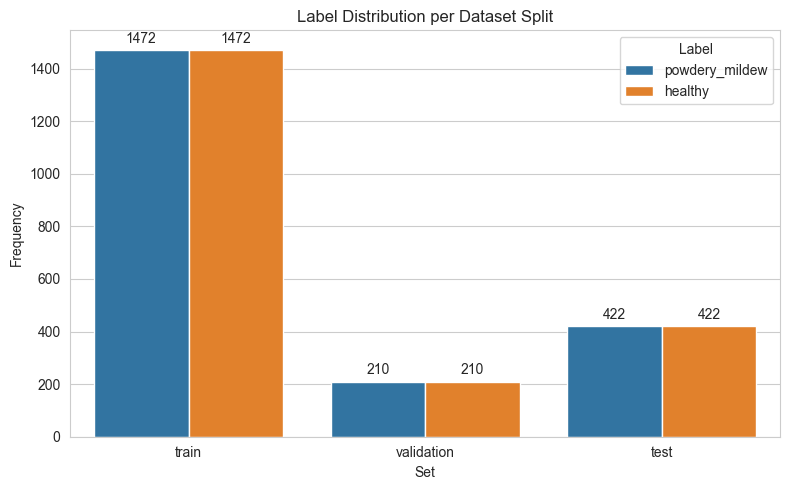

In [267]:
# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(dataset_dir + '/' + folder + '/' + label)))
        }
        for key, value in row.items():
            data[key].append(value)
        print(f"* {folder} - {label}: {row['Frequency']} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Assign the plot to ax
ax = sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)

plt.title("Label Distribution per Dataset Split")
plt.tight_layout()
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


### Pie Chart - Dataset Split Distribution

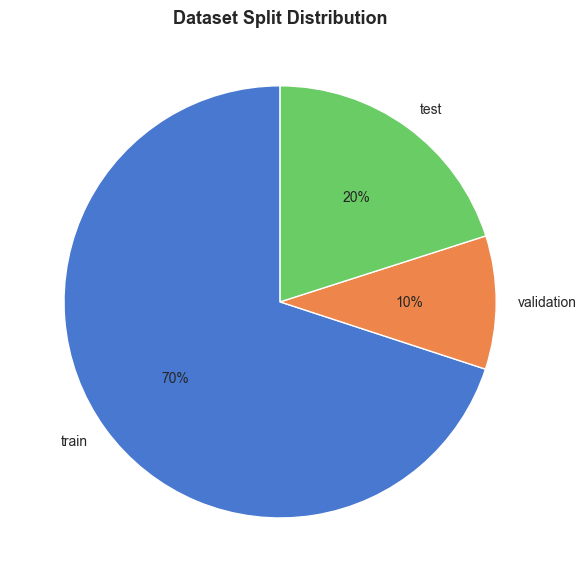

In [268]:
# Aggregate totals for each dataset split
split_totals = (
    df_freq.groupby('Set', as_index=False)['Frequency']
           .sum()
           .sort_values('Set', key=lambda s: s.map({'train':0,'validation':1,'test':2}))
)

# Calculate percentages
summary = split_totals.rename(columns={'Frequency': 'Images'})
summary['Percentage'] = (summary['Images'] / summary['Images'].sum() * 100).round(0)

# Prepare labels and values
set_labels = summary['Set'].tolist()
sizes = summary['Images'].tolist()

# Palette:
colors = sns.color_palette("muted", n_colors=len(set_labels))

# Label format: show % only
def autopct_pct_only(pct):
    return f"{pct:.0f}%"

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=set_labels,
    autopct=autopct_pct_only,
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Dataset Split Distribution", fontsize=13, weight='bold')
plt.tight_layout()

# Save and show
plt.savefig(f"{file_path}/split_distribution_pie.png", bbox_inches='tight', dpi=150)
plt.show()


---

## Set Seed

In [269]:
SEED = 27
np.random.seed(SEED)
tf.random.set_seed(SEED)

---

## Set Best Model Configuration

In [270]:
# Set batch size
batch_size = 32

# Set number of epochs
epochs = 25

# Model hyperparameters
kernel = (3, 3)
dropout = 0.3
activation = 'elu'
optimizer = 'adamax'

---

# Image Data Augmentation

### Image Data Generator

In [271]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [272]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Set Batch Size

In [273]:
batch_size = 20  # Set batch size

### Augment training image dataset

In [274]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_dir,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [275]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [276]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


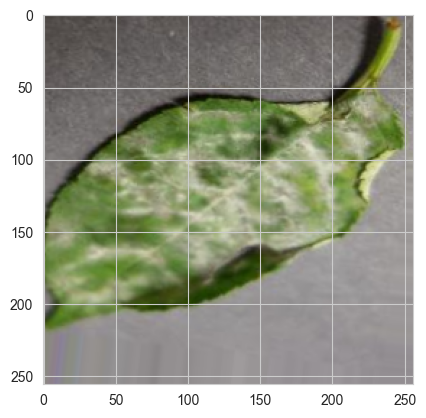

(20, 256, 256, 3)


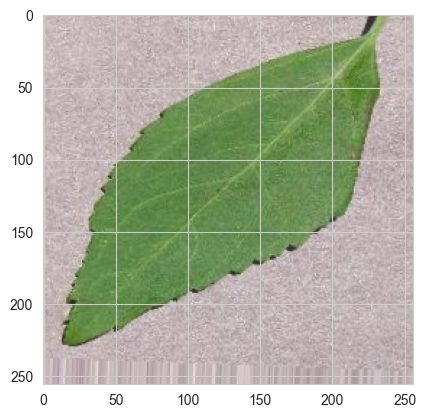

(20, 256, 256, 3)


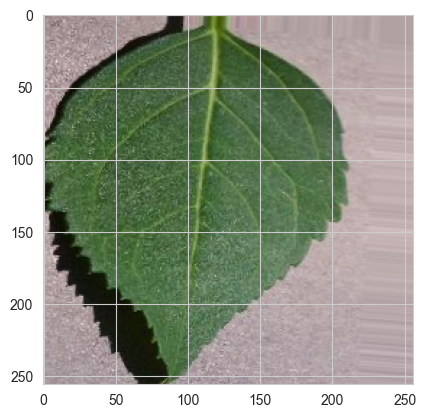

In [277]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation images

(20, 256, 256, 3)


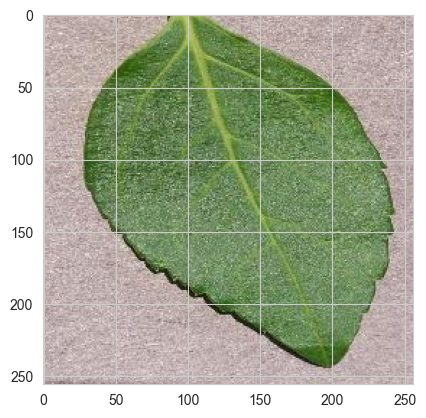

(20, 256, 256, 3)


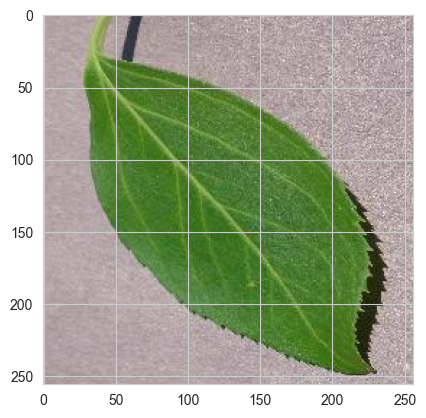

(20, 256, 256, 3)


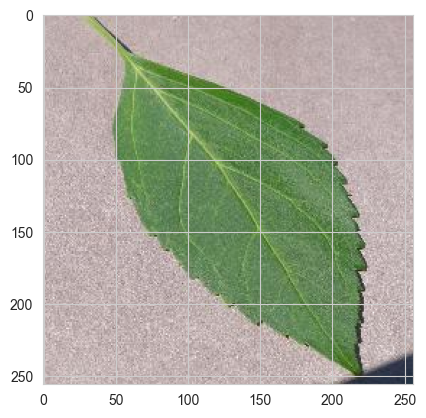

In [278]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented test images

(20, 256, 256, 3)


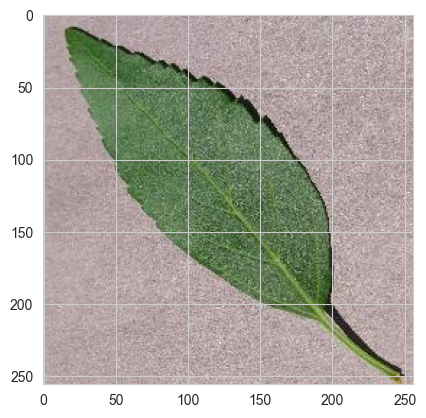

(20, 256, 256, 3)


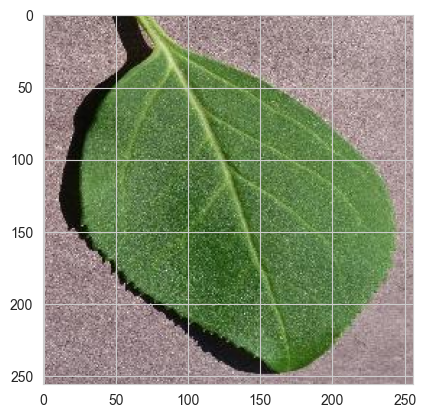

(20, 256, 256, 3)


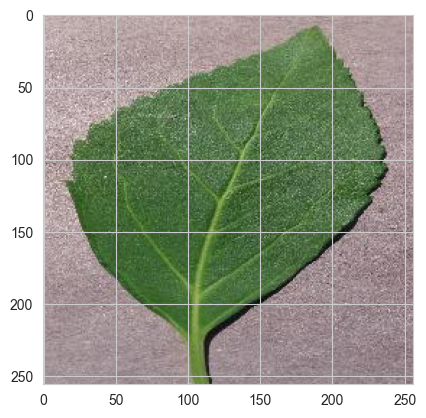

In [279]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [280]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/prod/class_indices.pkl']

---

# Model Creation

## ML Model

### Import Model Packages

In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Model

In [282]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=kernel,
              input_shape=image_shape, activation=activation, ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=kernel,
              input_shape=image_shape, activation=activation, ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=kernel,
              input_shape=image_shape, activation=activation, ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))

    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

### Model Summary

In [283]:
create_tf_model().summary()

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [284]:
cbs = [
    # Stop training if val_accuracy doesn't improve for 4 epochs, roll back to best weights:
    EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True, verbose=1),
    # Keep the best model:
    ModelCheckpoint(filepath=f"{file_path}/mildew_detector_model_{version}.keras", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    ]

## Fit Model for Model Training

In [285]:
model = create_tf_model()
model.fit(train_set,
          epochs=epochs,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=cbs,
          verbose=1
          )

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8028 - loss: 0.8838
Epoch 1: val_accuracy improved from None to 0.98333, saving model to outputs/prod/mildew_detector_model_v1.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9186 - loss: 0.3082 - val_accuracy: 0.9833 - val_loss: 0.0339
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 1.0000 - loss: 0.0162

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.98333 to 0.98571, saving model to outputs/prod/mildew_detector_model_v1.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.9857 - val_loss: 0.0309
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9818 - loss: 0.0515
Epoch 3: val_accuracy improved from 0.98571 to 0.99762, saving model to outputs/prod/mildew_detector_model_v1.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.9808 - loss: 0.0556 - val_accuracy: 0.9976 - val_loss: 0.0134
Epoch 4/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.9500 - loss: 0.0947
Epoch 4: val_accuracy did not improve from 0.99762
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9500 - loss: 0.0947 - val_accuracy: 0.9929 - val_loss: 0.0133
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9930 - loss: 0.0263
Epoch 5: val_accuracy did not improve from 0.99762
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - 

### Save Model

In [286]:
model.save(f"{file_path}/mildew_detector_model_{version}.keras")

#### Identified bug - see documentation

In [287]:
from keras.models import load_model
model = load_model("outputs/step_2/models/step_2_bs32_k3_do0.3_act-elu_opt-adamax_seed27.keras")
history = joblib.load("outputs/step_2/reports/history_step_2_bs32_k3_do0.3_act-elu_opt-adamax_seed27.pkl")

---

# Model Performance

## Model learning curve

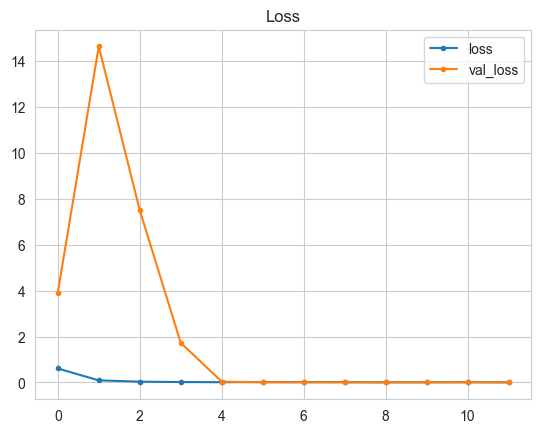

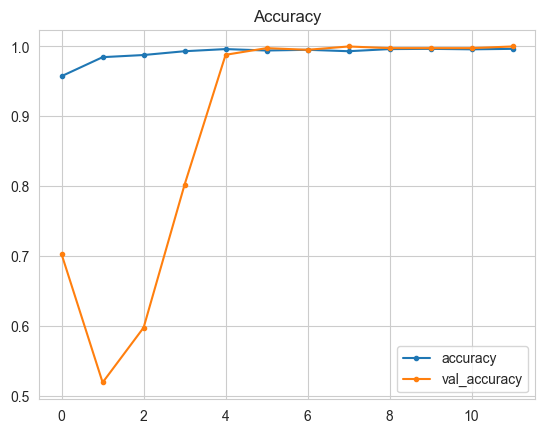

In [288]:
losses = pd.DataFrame(history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

### Evaluate Model on Test Set

In [289]:
evaluation = model.evaluate(test_set)


/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.0000 - loss: 0.0031


### Confusion Matrix

Found 2944 images belonging to 2 classes.

=== Train Set ===
Confusion Matrix:
 [[1469    3]
 [   0 1472]]

Classification Report:
                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00      1472
powdery_mildew       1.00      1.00      1.00      1472

      accuracy                           1.00      2944
     macro avg       1.00      1.00      1.00      2944
  weighted avg       1.00      1.00      1.00      2944


=== Validation Set ===
Confusion Matrix:
 [[210   0]
 [  0 210]]

Classification Report:
                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00       210
powdery_mildew       1.00      1.00      1.00       210

      accuracy                           1.00       420
     macro avg       1.00      1.00      1.00       420
  weighted avg       1.00      1.00      1.00       420


=== Test Set ===
Confusion Matrix:
 [[422   0]
 [  0 422]]

Classification Report:
                p

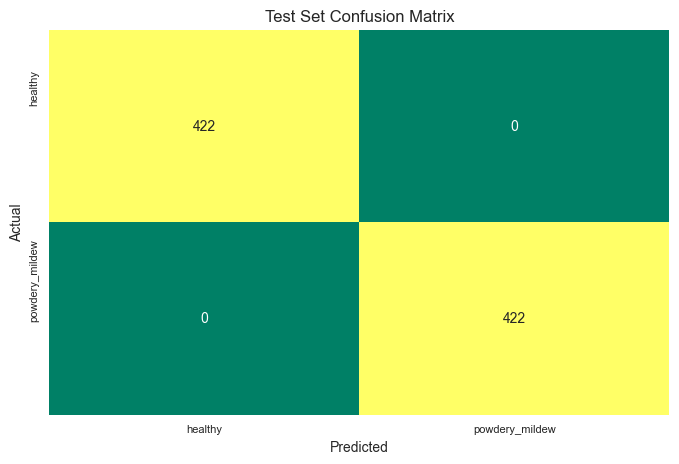

In [290]:
from sklearn.metrics import classification_report, confusion_matrix

# Non-shuffled copy of the train set for evaluation
train_eval = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# --- Classification report ---
def generate_report(model, gen, name):
    """Print confusion matrix and classification report for a given dataset."""
    gen.reset()
    preds = model.predict(gen, verbose=0)

    # Handle sigmoid (N,1) or softmax (N,2)
    y_pred = np.argmax(preds, axis=1) if (preds.ndim == 2 and preds.shape[1] == 2) else (preds.ravel() >= 0.5).astype(int)
    y_true = gen.classes[:len(y_pred)]

    classes = [k for k, _ in sorted(gen.class_indices.items(), key=lambda kv: kv[1])]
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} Set ===")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    return cm, classes


# --- Confusion matrix plot ---
def plot_confusion_matrix(cm, classes, name="Dataset", cmap='summer'):
    """Plot and save a confusion matrix for dataset."""
    length = len(classes)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=cmap, cbar=False, linewidths=0)
    plt.xticks(np.arange(length)+.5, classes, rotation=0, fontsize=8)
    plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Set Confusion Matrix")
    plt.savefig(f'{file_path}/confusion_matrix_{name.lower()}.png', bbox_inches='tight', dpi=150)
    plt.show()


# --- Run reports for all sets ---
cm_train, classes_train = generate_report(model, train_eval, "Train")
cm_val, classes_val = generate_report(model, validation_set, "Validation")
cm_test, classes_test = generate_report(model, test_set, "Test")

# --- Confusion Matrix Plot ---
plot_confusion_matrix(cm_test, classes_test, name="Test")

### Save Evaluation Pickle

In [291]:
joblib.dump(value=evaluation,
            filename=f"{file_path}/evaluation{version}.pkl")


['outputs/prod/evaluationv1.pkl']

## Predict on New Data

### Load Random Image as PIL

powdery_mildew
Image shape: (256, 256), Image mode: RGB


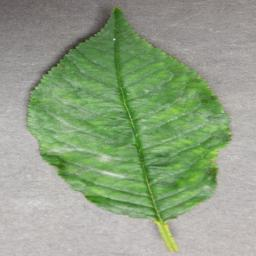

In [292]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] # 'healthy' or 'powdery_mildew'

print(label)

img_path = os.path.join(test_dir, label, os.listdir(os.path.join(test_dir, label))[pointer])
pil_image = image.load_img(img_path, target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


### Convert Image to Array and Prepare for Prediction

In [293]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict Class Probabilities

In [294]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1.0
powdery_mildew
